# ranger包

ranger is a fast implementation of **random forests (Breiman 2001) or recursive partitioning**, particularly suited for **high dimensional data**. Classification, regression, and survival forests are supported. **Classification and regression forests are implemented as in the original Random Forest (Breiman 2001)**, survival forests as in Random Survival Forests (Ishwaran et al. 2008). Includes implementations of extremely randomized trees (Geurts et al. 2006) and quantile regression forests (Meinshausen 2006).

ranger is written in C++, but a version for R is available, too. We recommend to use the R version. It is easy to install and use and the results are readily available for further analysis. The R version is as fast as the standalone C++ version.

https://github.com/imbs-hl/ranger

优点：
1. 变量无序类别数超过randomForest包允许的53个
2. 运行大大快于randomForest
3. 可以代价敏感--不知道怎么做
1. 可以提供类别判定概率
1. 有csrf，但很耗时
1. 可做extraTrees
1. 提供了“impurity_corrected”变量重要性评价

缺点：
1. 没有缺失值填补功能
1. 不提供proximity 

## 速度比测

In [1]:
options(warn=-1)    #忽略一切警告
options('width'=140)  #充分利用打印宽度
options(repr.plot.width=22, repr.plot.height=10)  #满幅


library(pacman)
p_load(randomForest,ranger,skimr,AmesHousing)
s <- skim_tee

ames <- as.data.frame(make_ames())

ames_c <- ames
ames_c[, "Sale_Price"] <- factor(ames_c[, "Sale_Price"] > 160000)
s(ames_c)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2930  
Number of columns          81    
_______________________          
Column type frequency:           
  factor                   47    
  numeric                  34    
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   skim_variable  n_missing complete_rate ordered n_unique top_counts                             
 1 MS_SubClass            0             1 FALSE         16 One: 1079, Two: 575, One: 287, One: 192
 2 MS_Zoning              0             1 FALSE          7 Res: 2273, Res: 462, Flo: 139, Res: 27 
 3 Street                 0             1 FALSE          2 Pav: 2918, Grv: 12                     
 4 Alley                  0             1 FALSE          3 No_: 2732, Gra: 120, P

In [2]:
system.time(rg <- ranger(Sale_Price ~ ., data = ames_c,seed=100)) 
set.seed(200)
system.time(rf <- randomForest(Sale_Price ~ ., data = ames_c)) 

   user  system elapsed 
   1.41    0.03    0.17 

   user  system elapsed 
   4.75    0.08    4.83 

In [3]:
rg

Ranger result

Call:
 ranger(Sale_Price ~ ., data = ames_c, seed = 100) 

Type:                             Classification 
Number of trees:                  500 
Sample size:                      2930 
Number of independent variables:  80 
Mtry:                             8 
Target node size:                 1 
Variable importance mode:         none 
Splitrule:                        gini 
OOB prediction error:             7.27 % 

In [4]:
rf


Call:
 randomForest(formula = Sale_Price ~ ., data = ames_c) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 8

        OOB estimate of  error rate: 7.03%
Confusion matrix:
      FALSE TRUE class.error
FALSE  1375   92  0.06271302
TRUE    114 1349  0.07792208

可见：ranger与randomForest参数相似，性能可比，ranger运行速度优势明显

## 变量重要性评测

ranger包提供了“impurity_corrected”变量重要性评价，克服了impurity倾向于类别多变量的问题

注：impurity_corrected机理:impurity的降低总量减去该自变量乱序后的impurity的降低量,乱序后的降低量是由于取值碰巧降低的部分

**分类问题**

In [5]:
# 生成数据--x1~x6与y独立
n <- 500    #数据量
set.seed(101)
x1 <- factor((sample(n) %% 2)) # 2种取值
x2 <- factor((sample(n) %% 10)) # 10种取值
x3 <- factor((sample(n) %% 20)) # 20种取值
x4 <- factor((sample(n) %% 25)) # 25种取值
x5 <- factor((sample(n) %% 50)) # 50种取值
x6 <- factor((sample(n) %% 100)) # 100种取值
y <- factor((sample(n) %% 2))

dt <- data.frame(x1, x2, x3, x4, x5, x6, y)
s(dt)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             500   
Number of columns          7     
_______________________          
Column type frequency:           
  factor                   7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts                
1 x1                    0             1 FALSE          2 0: 250, 1: 250            
2 x2                    0             1 FALSE         10 0: 50, 1: 50, 2: 50, 3: 50
3 x3                    0             1 FALSE         20 0: 25, 1: 25, 2: 25, 3: 25
4 x4                    0             1 FALSE         25 0: 20, 1: 20, 2: 20, 3: 20
5 x5                    0             1 FALSE         50 0: 10, 1: 10, 2: 10, 3: 10
6 x6   

In [6]:
# 独立性假设检验
(chisq.test(table(x1, y), simulate.p.value = TRUE)$p.value)
(chisq.test(table(x2, y), simulate.p.value = TRUE)$p.value)
(chisq.test(table(x3, y), simulate.p.value = TRUE)$p.value)
(chisq.test(table(x4, y), simulate.p.value = TRUE)$p.value)
(chisq.test(table(x5, y), simulate.p.value = TRUE)$p.value)
(chisq.test(table(x6, y), simulate.p.value = TRUE)$p.value)

[1] 0.1309345

[1] 0.2118941

[1] 0.9925037

[1] 0.1584208

[1] 0.5112444

[1] 0.3768116

可见 p值均较大，不能拒绝x1~x6与y独立

  |==================================================================================================================================| 100%

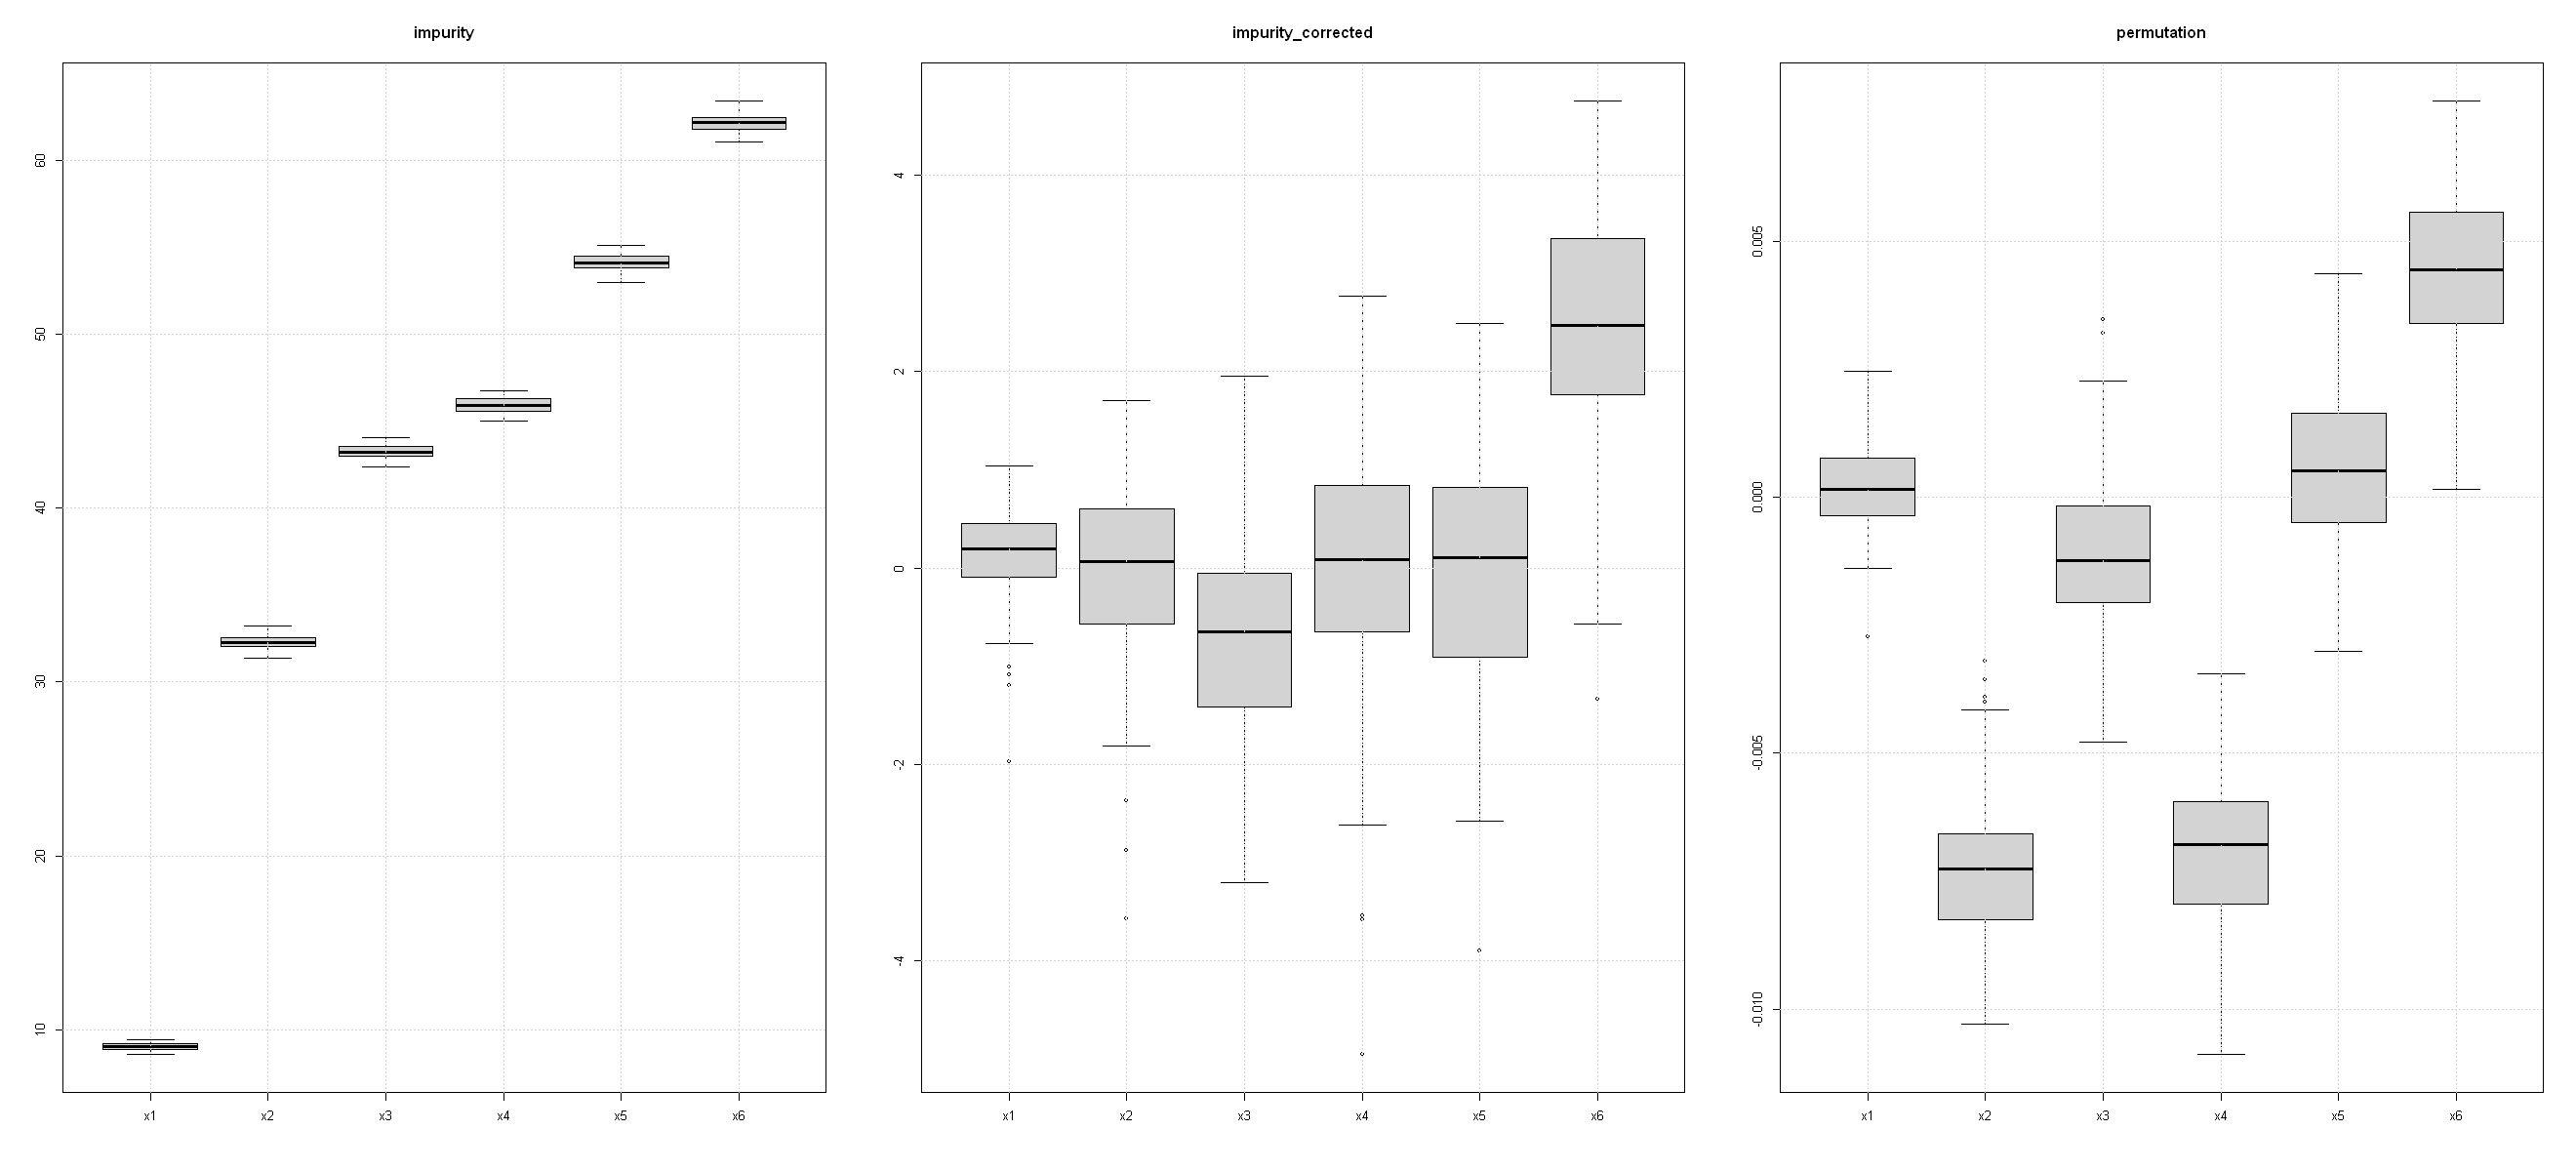

In [7]:
nr <- 100 # number of experiment

n <- 6
ImpIpt <- matrix(ncol = n, nrow = nr) # 用于存储多次实验得到Permutation Importance的数据
colnames(ImpIpt) <- paste("x", (1:n), sep = "") # 以变量名命名列
ImpIptc <- matrix(ncol = n, nrow = nr) # 用于存储多次实验得到Permutation Importance的数据
colnames(ImpIptc) <- paste("x", (1:n), sep = "") # 以变量名命名列
ImpPerm <- matrix(ncol = n, nrow = nr) # 用于存储多次实验得到Permutation Importance的数据
colnames(ImpPerm) <- paste("x", (1:n), sep = "") # 以变量名命名列

p_load(ranger)
pb <- txtProgressBar(style = 3)
for (i in 1:nr) {
  set.seed(i)
  rg1 <- ranger(y ~ ., data = dt, importance = "impurity")
  rg2 <- ranger(y ~ ., data = dt, importance = "impurity_corrected")
  rg3 <- ranger(y ~ ., data = dt, importance = "permutation")

  ImpIpt[i, ] <- rg1$variable.importance
  ImpIptc[i, ] <- rg2$variable.importance
  ImpPerm[i, ] <- rg3$variable.importance

  setTxtProgressBar(pb, i / nr)
}

par(mfrow = c(1, 3))
boxplot(ImpIpt, main = "impurity")
grid()
boxplot(ImpIptc, main = "impurity_corrected")
grid()
boxplot(ImpPerm, main = "permutation")
grid()

可见ranger的分类问题重要性评价：
- impurity算法倾向于类别多的变量
- impurity_corrected、permutation算法无此倾向

**回归问题**

In [26]:
# 生成数据--x1~x6与y独立
n <- 1000    #数据量
set.seed(101)
x1 <- factor((sample(n) %% 2)) # 2种取值
x2 <- factor((sample(n) %% 10)) # 10种取值
x3 <- factor((sample(n) %% 20)) # 20种取值
x4 <- factor((sample(n) %% 25)) # 25种取值
x5 <- factor((sample(n) %% 50)) # 50种取值
x6 <- factor((sample(n) %% 100)) # 100种取值
y <- runif(n, min = 0, max = 1)

dt <- data.frame(x1, x2, x3, x4, x5, x6, y)
s(dt)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          7     
_______________________          
Column type frequency:           
  factor                   6     
  numeric                  1     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts                    
1 x1                    0             1 FALSE          2 0: 500, 1: 500                
2 x2                    0             1 FALSE         10 0: 100, 1: 100, 2: 100, 3: 100
3 x3                    0             1 FALSE         20 0: 50, 1: 50, 2: 50, 3: 50    
4 x4                    0             1 FALSE         25 0: 40, 1: 40, 2: 40, 3: 40    
5 x5                    0            

In [27]:
# 独立性假设检验
kruskal.test(x1 ~ y)$p.value
kruskal.test(x2 ~ y)$p.value
kruskal.test(x3 ~ y)$p.value
kruskal.test(x4 ~ y)$p.value
kruskal.test(x5 ~ y)$p.value
kruskal.test(x6 ~ y)$p.value

[1] 0.4940499

[1] 0.4940499

[1] 0.4940499

[1] 0.4940499

[1] 0.4940499

[1] 0.4940499

可见 p值均较大，不能拒绝x1~x6与y独立

  |==================================================================================================================================| 100%

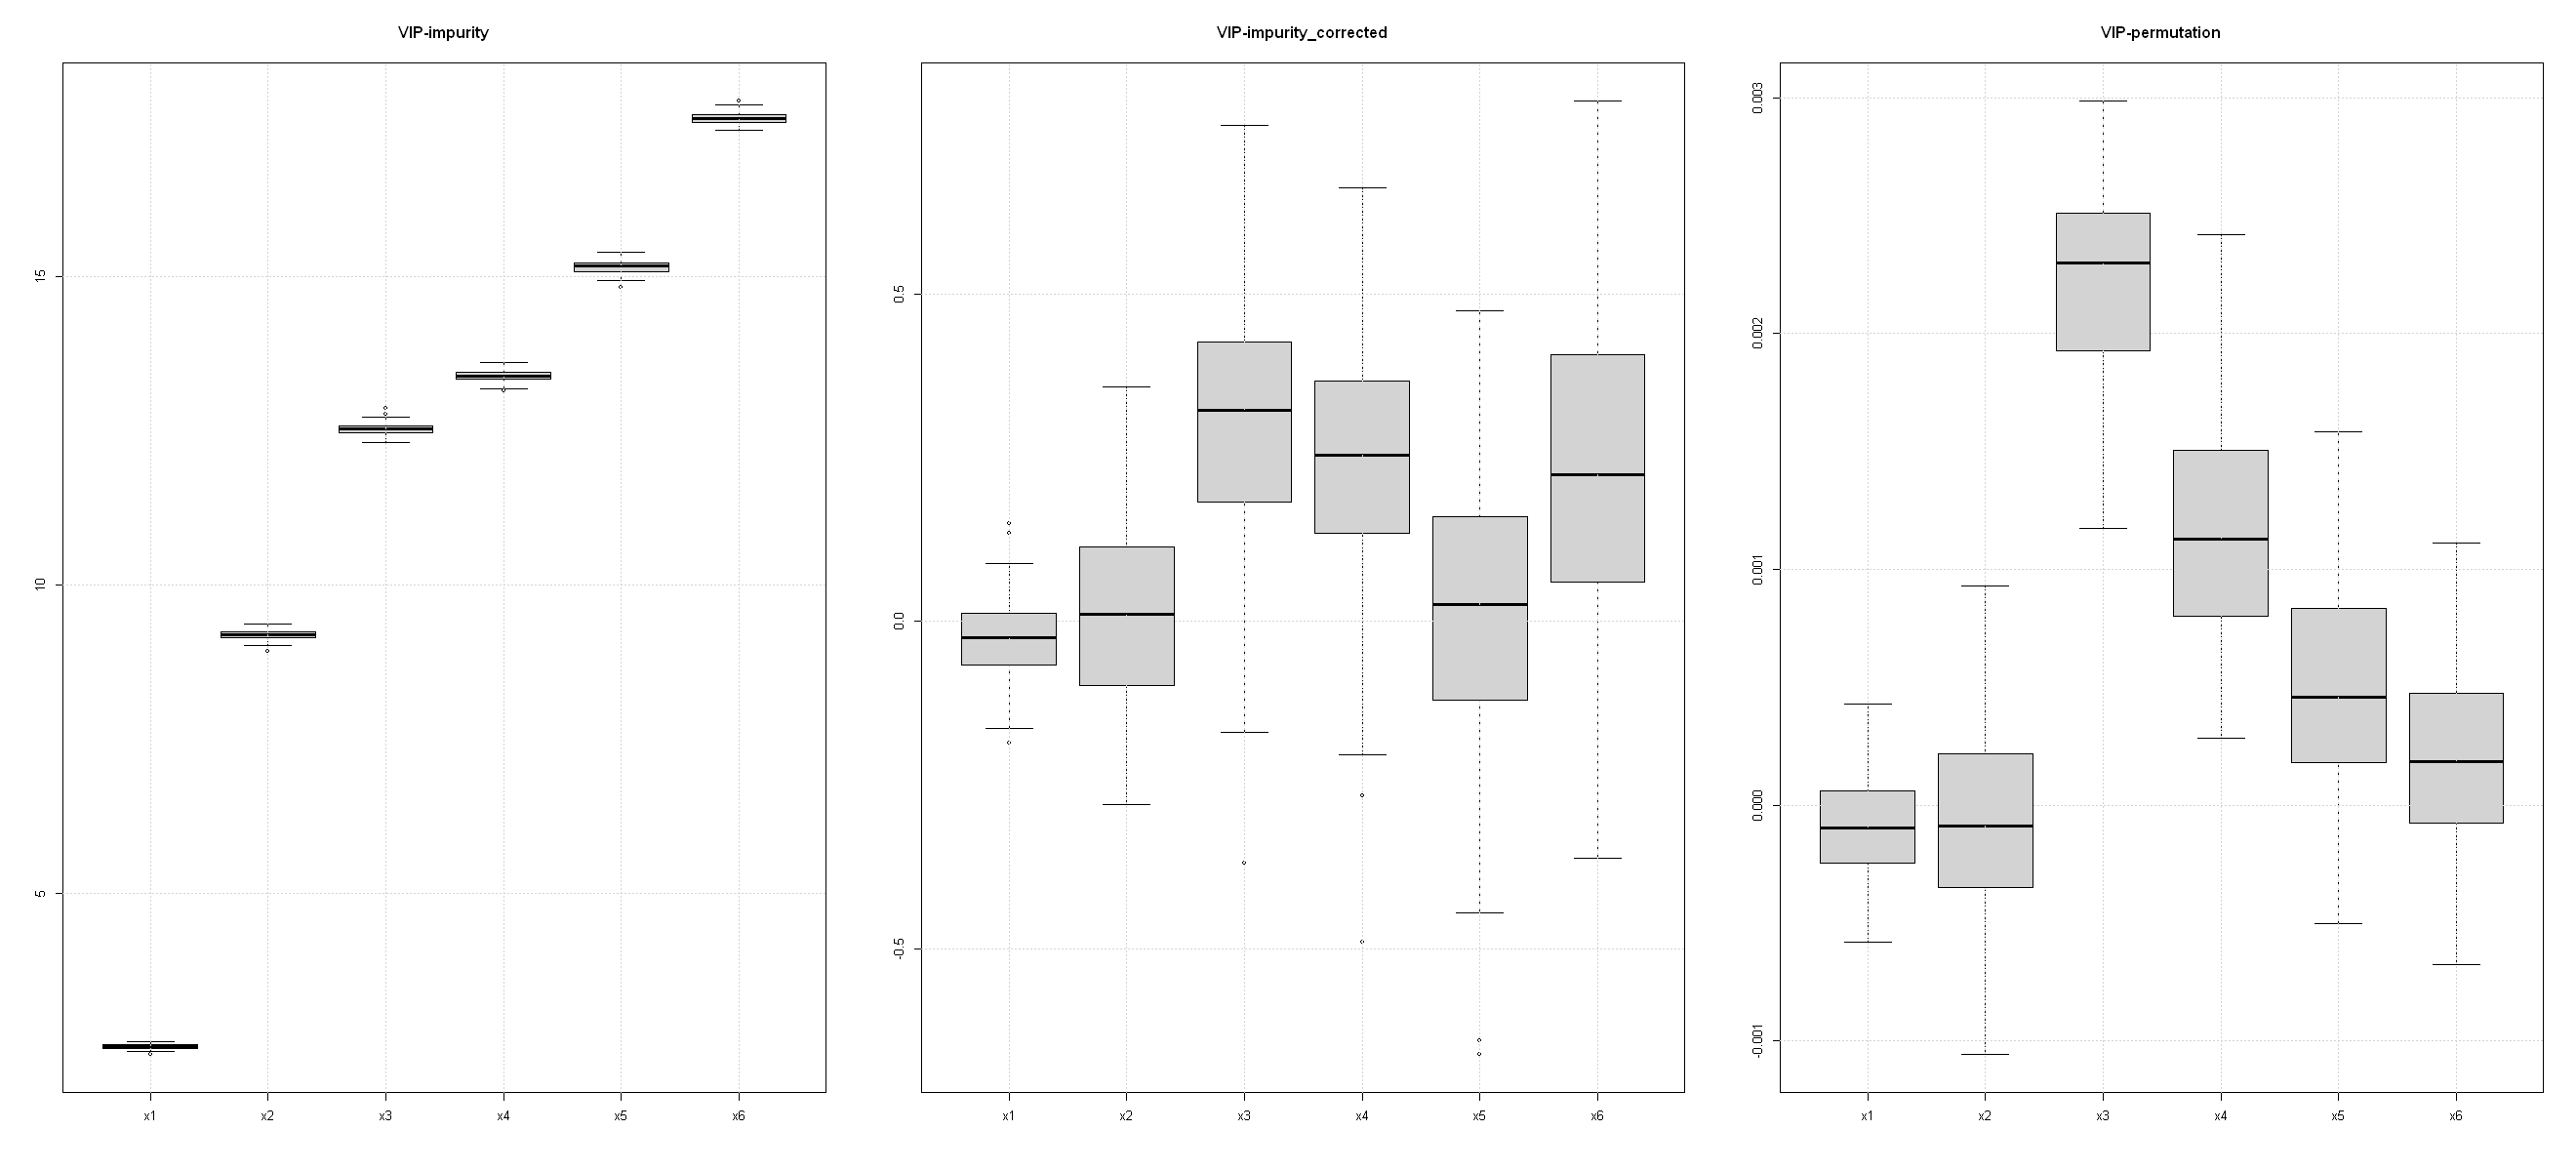

In [10]:
nr <- 100 # number of experiment

n <- 6
ImpIpt <- matrix(ncol = n, nrow = nr) # 用于存储多次实验得到Permutation Importance的数据
colnames(ImpIpt) <- paste("x", (1:n), sep = "") # 以变量名命名列
ImpIptc <- matrix(ncol = n, nrow = nr) # 用于存储多次实验得到Permutation Importance的数据
colnames(ImpIptc) <- paste("x", (1:n), sep = "") # 以变量名命名列
ImpPerm <- matrix(ncol = n, nrow = nr) # 用于存储多次实验得到Permutation Importance的数据
colnames(ImpPerm) <- paste("x", (1:n), sep = "") # 以变量名命名列

p_load(ranger)
pb <- txtProgressBar(style = 3)
for (i in 1:nr) {
  set.seed(i)
  rg1 <- ranger(y ~ ., data = dt, importance = "impurity")
  rg2 <- ranger(y ~ ., data = dt, importance = "impurity_corrected")
  rg3 <- ranger(y ~ ., data = dt, importance = "permutation")

  ImpIpt[i, ] <- rg1$variable.importance
  ImpIptc[i, ] <- rg2$variable.importance
  ImpPerm[i, ] <- rg3$variable.importance

  setTxtProgressBar(pb, i / nr)
}

par(mfrow = c(1, 3))
boxplot(ImpIpt, main = "VIP-impurity")
grid()
boxplot(ImpIptc, main = "VIP-impurity_corrected")
grid()
boxplot(ImpPerm, main = "VIP-permutation")
grid()

可见ranger的回归问题重要性评价：
- impurity算法倾向于类别多的变量
- impurity_corrected、permutation算法无此倾向

**Compute variable importance with p-values**

--可以设置一个显著性水平，作为变量是否重要的阈值

数据集 $friedman1$按此方式生成模拟数据：自变量 $\{X_j\}^{10}_ {j=1}\overset{iid}{\sim} U(0,1)$，$Y=10\sin(\pi X_1X_2)+20(X_3-0.5)^2+10X_4+5X_5+\epsilon$ ,  其中$\epsilon\sim N(0,\sigma)$ ，请注意$X_6 \sim X_{10} $ 独立于 $Y$，方便检验算法判断自变量重要性。

In [11]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 15, repr.plot.height = 10) # 满幅

p_load(rpart,ranger,skimr,treemisc)
s <- skim_tee

In [12]:
set.seed(943) # for reproducibility
fr <- treemisc::gen_friedman1(1000, nx = 10, sigma = 0.1)
fr$y <- factor(fr$y > 14.1)
s(fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             1000  
Number of columns          11    
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  10    
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts        
1 y                     0             1 FALSE          2 TRU: 506, FAL: 494

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   skim_variable n_missing complete_rate  mean    sd        p0   p25   p50   p75  p100 hist 
 1 x1                    0             1 0.505 0.294 0.00129   0.238 0.511 0.769 1.00  ▇▇▇

In [13]:
#将数据集1:1随机分割成训练集和测试集
set.seed(100)
I <- sample(nrow(fr),nrow(fr)*0.5)
train_fr <- fr[I,]
test_fr <- fr[-I,]
s(train_fr)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             500   
Number of columns          11    
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  10    
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts        
1 y                     0             1 FALSE          2 FAL: 254, TRU: 246

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   skim_variable n_missing complete_rate  mean    sd        p0   p25   p50   p75  p100 hist 
 1 x1                    0             1 0.506 0.290 0.00166   0.251 0.507 0.768 0.996 ▇▇▇

In [14]:
set.seed(71)
rf_fr <- ranger(y ~ ., data = train_fr, importance = "impurity_corrected")
importance_pvalues(rf_fr, method = "altmann", formula = y ~ ., data = train_fr)

,importance,pvalue
x1,30.65108821,0.00990099
x2,28.63528696,0.00990099
x3,5.72731364,0.00990099
x4,33.55785631,0.00990099
x5,7.72685797,0.00990099
x6,0.53424710,0.41584158
x7,-0.38797612,0.67326733
x8,-1.11848661,0.85148515
x9,0.95760903,0.24752475
x10,0.01910408,0.52475248


In [15]:
set.seed(71)
rf_fr <- ranger(y ~ ., data = train_fr, importance = "impurity_corrected")
importance_pvalues(rf_fr, method = "janitza")

,importance,pvalue
x1,30.65108821,0.00
x2,28.63528696,0.00
x3,5.72731364,0.00
x4,33.55785631,0.00
x5,7.72685797,0.00
x6,0.53424710,0.25
x7,-0.38797612,0.75
x8,-1.11848661,1.00
x9,0.95760903,0.25
x10,0.01910408,0.50


若以0.05作为显著性水平，可以清晰地判断出$X_6 \sim X_{10} $不重要

## 代价敏感分类

In [16]:
library(pacman)

options(warn = -1) # 忽略一切警告
options("width" = 140) # 充分利用打印宽度
options(repr.plot.width = 22, repr.plot.height = 10) # 满幅

p_load(ranger, AppliedPredictiveModeling, skimr)
s <- skim_tee

**导入、改造、勘察数据**

In [17]:
data(abalone)
ab <- abalone
ab$Rings <- factor((ab$Rings) > 12, labels = c("L", "H"))
s(ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             4177  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts               
1 Type                  0             1 FALSE          3 M: 1528, I: 1342, F: 1307
2 Rings                 0             1 FALSE          2 L: 3484, H: 693          

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 h

可见目标变量Rings的类别并不平衡，数量L类约为H类的5倍

假定H类被错判的代价为5，L类被错判的代价为1

**将数据随机平分为训练集和测试集：**

In [18]:
set.seed(100)
i <- sample(nrow(ab), nrow(ab) * 0.5)
tr_ab <- ab[i, ]
te_ab <- ab[-i, ]
s(tr_ab)

── Data Summary ────────────────────────
                           Values
Name                       data  
Number of rows             2088  
Number of columns          9     
_______________________          
Column type frequency:           
  factor                   2     
  numeric                  7     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts            
1 Type                  0             1 FALSE          3 M: 776, I: 675, F: 637
2 Rings                 0             1 FALSE          2 L: 1737, H: 351       

── Variable type: numeric ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean     sd     p0    p25   p50   p75  p100 hist 
1 Lo

In [19]:
cm <- matrix(c(0,1,5,0), nrow = 2, byrow = TRUE)  #cost matrix

In [20]:
(levels(tr_ab$Rings))

[1] "L" "H"

### CaseWeight法

In [21]:
cw <- ifelse(tr_ab$Rings == "H",5,1) 
set.seed(711)
rg_ab1 <- ranger(Rings ~ .,  data = tr_ab, case.weights = cw, min.node.size = 100)  
#min.node.size不能太小，否则case.weights没有施展空间
sum(matrix(table(te_ab$Rings, predict(rg_ab1, te_ab, type = "response")$predictions) * cm))

[1] 737

### ClassWeight法

In [22]:
set.seed(711)
rg_ab2 <- ranger(Rings ~ .,  data = tr_ab, class.weights = c(1,5), num.trees = 1000, min.node.size=100)
#min.node.size不能太小，否则class.weights没有施展空间
sum(matrix(table(te_ab$Rings, predict(rg_ab2, te_ab, type = "response")$predictions) * cm))

[1] 737

In [23]:
(rf <- ranger(Sale_Price ~ ., data = ames, splitrule= "extratrees")) 

Ranger result

Call:
 ranger(Sale_Price ~ ., data = ames, splitrule = "extratrees") 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      2930 
Number of independent variables:  80 
Mtry:                             8 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        extratrees 
Number of random splits:          1 
OOB prediction error (MSE):       752661680 
R squared (OOB):                  0.8820628 

In [24]:
(rf <- ranger(Sale_Price ~ ., data = ames, splitrule= "maxstat"))   #splitrule="beta"等效

Ranger result

Call:
 ranger(Sale_Price ~ ., data = ames, splitrule = "maxstat") 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      2930 
Number of independent variables:  80 
Mtry:                             8 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        maxstat 
OOB prediction error (MSE):       890477117 
R squared (OOB):                  0.860468 

## 分位数回归

普通线性回归（Ordinary linear regression，OLS）模型关注的是均值，研究的是在某些解释变量在取值固定的条件下响应变量的期望均值，模型估计方法是最小二乘法，使各个样本残差平方和最小。但是普通线性回归最基本的假设是残差满足正态分布、随机独立、方差齐同，现实中这些条件常常得不到满足。如果样本数据中存在异常值，普通线性回归模型估计值可能会存在较大偏差。有时候我们不仅希望研究响应变量的期望均值，而且希望能探索响应变量的全局分布（比如响应变量的某个分位数），这时候就需要分位数回归了。

In [25]:
rf <- ranger(mpg ~ ., mtcars[1:26, ], quantreg = TRUE)
pred <- predict(rf, mtcars[27:32, ], type = "quantiles", quantiles = c(0.1, 0.5, 0.9))
pred$predictions

quantile= 0.1,quantile= 0.5,quantile= 0.9
21.0,22.8,32.4
21.0,22.8,32.4
13.3,15.5,30.4
15.2,21.0,22.8
13.3,14.3,21.0
21.0,22.8,32.4
